## Approach

   1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. Collection processed in this notebook is SEDAC gridded population density.
   2. Pass the STAC item into raster API `/stac/tilejson.json` endpoint
   3. We'll visualize two tiles (side-by-side) allowing for comparison of each of the time points using `folium.plugins.DualMap`
   4. After the visualization, we'll perform zonal statistics for a given polygon.
   

## About the Data

The SEDAC Gridded Population of the World: Population Density, v4.11 dataset provides annual estimates of population density for the years 2000, 2005, 2010, 2015, and 2020 on a 30 arc-second (~1 km) grid. These data can be used for assessing disaster impacts, risk mapping, and any other applications that include a human dimension. This population density dataset is provided by NASA’s Socioeconomic Data and Applications Center (SEDAC) hosted by the Center for International Earth Science Information Network (CIESIN) at Columbia University. The population estimates are provided as a continuous raster for the entire globe.

# Installing the Required Libraries.
Please run the next cell to install all the required libraries to run the notebook.

In [1]:
%pip install requests
%pip install folium
%pip install rasterstats
%pip install pystac_client

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Querying the STAC API

In [2]:
import requests
from folium import Map, TileLayer
from pystac_client import Client

In [3]:
# Provide STAC and RASTER API endpoints
STAC_API_URL = "http://ghg.center/api/stac"
RASTER_API_URL = "https://ghg.center/api/raster"

#Please use the collection name similar to the one used in STAC collection.
# Name of the collection for SEDAC population density dataset. 
collection_name = "sedac-popdensity-yeargrid5yr-v4.11"

In [4]:
# Fetching the collection from STAC collections using appropriate endpoint.
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'sedac-popdensity-yeargrid5yr-v4.11',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/sedac-popdensity-yeargrid5yr-v4.11/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/sedac-popdensity-yeargrid5yr-v4.11'}],
 'title': 'SEDAC Gridded World Population Data',
 'assets': None,
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2000-01-01T00:00:00+00:00',
     '2020-12-31T00:00:00+00:00']]}},
 'license': 'CC-BY-4.0',
 'keywords': None,
 'providers': None,
 'summaries': {'datetime': ['2000-01-01T00:00:00Z',
   '2005-01-01T00:00:00Z',
   '2010-01-01T00:00:00Z',
   '2015-01-01T00:00:00Z',
   '2020-01-01T00:00:00Z']},


Examining the contents of our `collection` under `summaries` we see that the data is available from January 2000 to December 2020. By looking at the `dashboard:time density` we observe that the data is available for the years 2000, 2005, 2010, 2015, 2020. 

In [5]:
def get_item_count(collection_id):
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)

        if not response.ok:
            print("error getting items")
            exit()

        stac = response.json()
        count += int(stac["context"].get("returned", 0))
        next = [link for link in stac["links"] if link["rel"] == "next"]

        if not next:
            break
        items_url = next[0]["href"]

    return count

In [6]:
# Check total number of items available
number_of_items = get_item_count(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit={number_of_items}").json()["features"]
print(f"Found {len(items)} items")

Found 5 items


In [7]:
items[0]

{'id': 'sedac-popdensity-yeargrid5yr-v4.11-2020',
 'bbox': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/sedac-popdensity-yeargrid5yr-v4.11'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/sedac-popdensity-yeargrid5yr-v4.11'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/sedac-popdensity-yeargrid5yr-v4.11/items/sedac-popdensity-yeargrid5yr-v4.11-2020'}],
 'assets': {'population-density': {'href': 's3://ghgc-data-store/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2020_30_sec_2020.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Population densit

Below, we are entering the minimum and maximum values to provide our upper and lower bounds in `rescale_values`.

## Exploring Changes in the World Population Density using the Raster API

We will explore changes in population density in urban regions. In this notebook, we'll explore the changes in population density over time. We'll then visualize the outputs on a map using `folium`. 

In [8]:
# to access the year value from each item more easily, this will let us query more explicity by year and month (e.g., 2020-02)
items = {item["properties"]["start_datetime"][:7]: item for item in items} 
asset_name = "population-density"

In [9]:
rescale_values = {"max":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["max"], "min":items[list(items.keys())[0]]["assets"][asset_name]["raster:bands"][0]["histogram"]["min"]}

Now we will pass the item id, collection name, and `rescaling_factor` to the `Raster API` endpoint. We will do this twice, once for January 2000 and again for January 2020, so that we can visualize each event independently. 

In [10]:
color_map = "rainbow" # please select the color ramp from matplotlib library.
january_2020_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2020-01']['collection']}&item={items['2020-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2020_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=sedac-popdensity-yeargrid5yr-v4.11&item=sedac-popdensity-yeargrid5yr-v4.11-2020&assets=population-density&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-1505.7174072265625%2C30795.859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'center': [-8.526512829121202e-14, -4.263256414560601e-14, 0]}

In [11]:
january_2000_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items['2000-01']['collection']}&item={items['2000-01']['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}", 
).json()
january_2000_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=sedac-popdensity-yeargrid5yr-v4.11&item=sedac-popdensity-yeargrid5yr-v4.11-2000&assets=population-density&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-1505.7174072265625%2C30795.859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'center': [-8.526512829121202e-14, -4.263256414560601e-14, 0]}

## Visualizing Population Density.


In [12]:
# We'll import folium to map and folium.plugins to allow mapping side-by-side
import folium
import folium.plugins

# Set initial zoom and center of map for population density Layer
map_ = folium.plugins.DualMap(location=(34, -118), zoom_start=6)

# January 2020
map_layer_2020 = TileLayer(
    tiles=january_2020_tile["tiles"][0],
    attr="GHG",
    opacity=1,
)
map_layer_2020.add_to(map_.m1)

# January 2000
map_layer_2000 = TileLayer(
    tiles=january_2000_tile["tiles"][0],
    attr="GHG",
    opacity=1,
)
map_layer_2000.add_to(map_.m2)

# visualising the map
map_



# Calculating Zonal Statistics

## 

In [13]:
# Texas, USA
texas_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                # [13.686159004559698, -21.700046934333145],
                # [13.686159004559698, -23.241974326585833],
                # [14.753560168039911, -23.241974326585833],
                # [14.753560168039911, -21.700046934333145],
                # [13.686159004559698, -21.700046934333145],
                [-95, 29],
                [-95, 33],
                [-104, 33],
                [-104,29],
                [-95, 29]
            ]
        ],
        "type": "Polygon",
    },
}

In [14]:
# We'll plug in the coordinates for a location
# central to the study area and a reasonable zoom level

import folium

aoi_map = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=6,
)

folium.GeoJson(texas_aoi, name="Texas, USA").add_to(aoi_map)
aoi_map

In [15]:
# Check total number of items available
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=300"
).json()["features"]
print(f"Found {len(items)} items")

Found 5 items


In [16]:
# Explore one item to see what it contains
items[0]

{'id': 'sedac-popdensity-yeargrid5yr-v4.11-2020',
 'bbox': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/sedac-popdensity-yeargrid5yr-v4.11'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/collections/sedac-popdensity-yeargrid5yr-v4.11'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://ghg.center/api/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://ghg.center/api/stac/collections/sedac-popdensity-yeargrid5yr-v4.11/items/sedac-popdensity-yeargrid5yr-v4.11-2020'}],
 'assets': {'population-density': {'href': 's3://ghgc-data-store/sedac-popdensity-yeargrid5yr-v4.11/gpw_v4_population_density_rev11_2020_30_sec_2020.tif',
   'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
   'roles': ['data', 'layer'],
   'title': 'Population densit

In [17]:
# the bounding box should be passed to the geojson param as a geojson Feature or FeatureCollection
def generate_stats(item, geojson):
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()
    return {
        **result["properties"],
        "start_datetime": item["properties"]["start_datetime"],
    }

With the function above we can generate the statistics for the AOI.

In [18]:
%%time
stats = [generate_stats(item, texas_aoi) for item in items]

CPU times: user 84.8 ms, sys: 10.4 ms, total: 95.1 ms
Wall time: 6.83 s


In [19]:
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 18419.53125,
   'mean': 58.53235268568119,
   'count': 518400.0,
   'sum': 30321222.0,
   'std': 335.6929520668643,
   'median': 0.4415185749530792,
   'majority': 0.0,
   'minority': 1.0156783218917553e-06,
   'unique': 304154.0,
   'histogram': [[512941.0,
     4330.0,
     627.0,
     91.0,
     22.0,
     7.0,
     1.0,
     4.0,
     0.0,
     2.0],
    [0.0,
     1841.953125,
     3683.90625,
     5525.859375,
     7367.8125,
     9209.765625,
     11051.71875,
     12893.671875,
     14735.625,
     16577.578125,
     18419.53125]],
   'valid_percent': 99.93,
   'masked_pixels': 375.0,
   'valid_pixels': 518025.0,
   'percentile_2': 0.0,
   'percentile_98': 898.1920996093824}},
 'start_datetime': '2020-01-01T00:00:00+00:00'}

In [20]:
import pandas as pd


def clean_stats(stats_json) -> pd.DataFrame:
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["start_datetime"])
    return df


df = clean_stats(stats)
df.head(5)

,start_datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2020-01-01T00:00:00+00:00,0.0,18419.531250,58.532353,518400.0,30321222.0,335.692952,0.441519,0.0,0.000001,304154.0,"[[512941.0, 4330.0, 627.0, 91.0, 22.0, 7.0, 1....",99.93,375.0,518025.0,0.0,898.192100,2020-01-01 00:00:00+00:00
1,2015-01-01T00:00:00+00:00,0.0,16791.851562,52.619171,518400.0,27258046.0,302.069689,0.432173,0.0,0.000001,304042.0,"[[513082.0, 4248.0, 572.0, 87.0, 20.0, 9.0, 1....",99.93,375.0,518025.0,0.0,802.884363,2015-01-01 00:00:00+00:00
2,2010-01-01T00:00:00+00:00,0.0,15308.004883,47.493947,518400.0,24603052.0,273.645484,0.426434,0.0,0.000001,304161.0,"[[513182.0, 4159.0, 560.0, 83.0, 25.0, 9.0, 1....",99.93,375.0,518025.0,0.0,722.900876,2010-01-01 00:00:00+00:00
3,2005-01-01T00:00:00+00:00,0.0,13955.282227,43.030074,518400.0,22290654.0,249.332851,0.417514,0.0,0.000001,304215.0,"[[513253.0, 4076.0, 561.0, 91.0, 27.0, 10.0, 1...",99.93,375.0,518025.0,0.0,648.693762,2005-01-01 00:00:00+00:00
4,2000-01-01T00:00:00+00:00,0.0,12722.096680,39.124289,518400.0,20267360.0,228.324844,0.405285,0.0,0.000001,304130.0,"[[513329.0, 3965.0, 580.0, 104.0, 29.0, 8.0, 4...",99.93,375.0,518025.0,0.0,582.569736,2000-01-01 00:00:00+00:00


## Visualizing the Data as a Time Series
We can now explore the SEDAC population density dataset time series available for the Texas, Dallas area of USA. We can plot the dataset using the code below:

Text(0.5, 1.0, 'Population density over Texas, Dallas (2000-2020)')

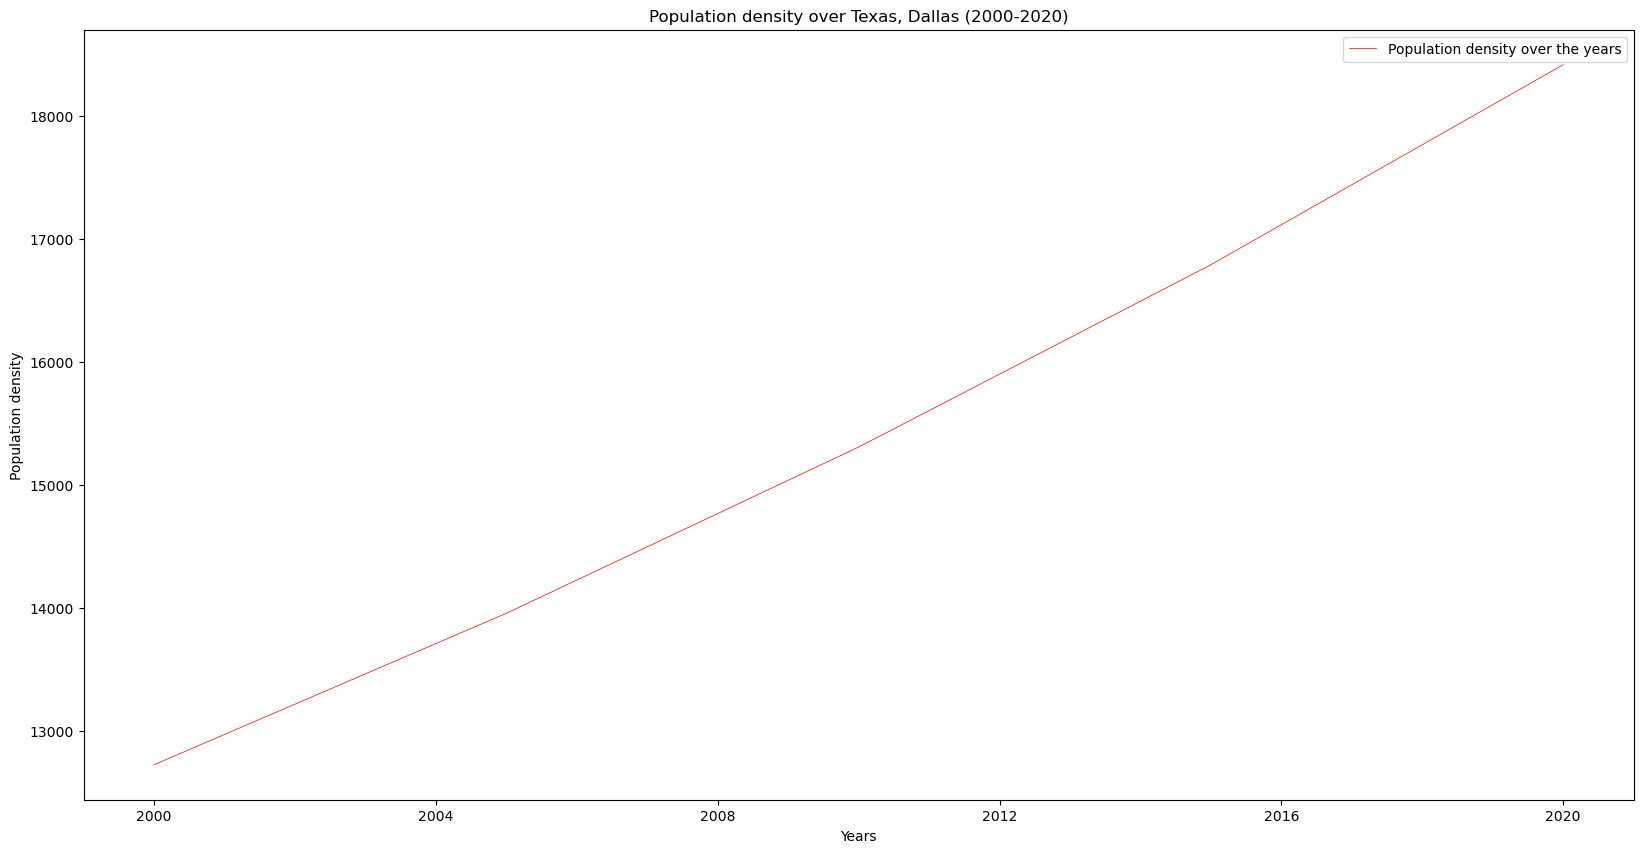

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))


plt.plot(
    df["date"],
    df["max"],
    color="red",
    linestyle="-",
    linewidth=0.5,
    label="Population density over the years",
)

plt.legend()
plt.xlabel("Years")
plt.ylabel("Population density")
plt.title("Population density over Texas, Dallas (2000-2020)")

In [22]:
print(items[2]["properties"]["start_datetime"])

2010-01-01T00:00:00+00:00


In [23]:
october_tile = requests.get(
    f"{RASTER_API_URL}/stac/tilejson.json?collection={items[2]['collection']}&item={items[2]['id']}"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}",
).json()
october_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?collection=sedac-popdensity-yeargrid5yr-v4.11&item=sedac-popdensity-yeargrid5yr-v4.11-2010&assets=population-density&color_formula=gamma+r+1.05&colormap_name=rainbow&rescale=-1505.7174072265625%2C30795.859375'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 179.99999999999983, 89.99999999999991],
 'center': [-8.526512829121202e-14, -4.263256414560601e-14, 0]}

In [24]:
# Use bbox initial zoom and map
# Set up a map located w/in event bounds
import folium

aoi_map_bbox = Map(
    tiles="OpenStreetMap",
    location=[
        30,-100
    ],
    zoom_start=8,
)

map_layer = TileLayer(
    tiles=october_tile["tiles"][0],
    attr="GHG", opacity = 0.5
)

map_layer.add_to(aoi_map_bbox)

aoi_map_bbox

## Summary

In this notebook we have successfully explored, analyzed and visualized the STAC collection for the SEDAC Gridded World Population Density dataset.